In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import logging
import pickle
from sellibrary.text_file_loader import load_feature_matrix
from sellibrary.filter_only_golden import FilterGolden
from sellibrary.util.const import Const


from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.learning_curve import learning_curve 
from sklearn.cross_validation import ShuffleSplit, train_test_split 
from sklearn.grid_search import GridSearchCV

from sellibrary.gbrt import GBRTWrapper
from sellibrary.util.test_train_splitter import DataSplitter

/Users/dsluis/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/dsluis/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)
/Users/dsluis/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.

# Setup Environment

In [2]:
from sellibrary.locations import FileLocations
INTERMEDIATE_PATH = FileLocations.get_dropbox_intermediate_path()
const = Const()
handler = logging.StreamHandler()
handler.setFormatter(logging.Formatter('%(asctime)s %(name)-12s %(levelname)-8s %(message)s'))
logger = logging.getLogger(__name__)
logger.addHandler(handler)
logger.propagate = False
logger.setLevel(logging.INFO)


# Setup variables


In [53]:

# INPUT_FILENAME = 'efficient_1_features.txt'
# FEATURE_NAMES = const.efficient_1_feature_names
# OUTPUT_MODEL_NAME = 'efficient_model_1.pickle'


INPUT_FILENAME = 'efficient_2_features.txt'
FEATURE_NAMES = const.efficient_2_feature_names
OUTPUT_MODEL_NAME = 'efficient_model_2.pickle'


# Load Data

In [54]:
X_eff_1, y_eff_1, docid_array_eff_1, entity_id_array_eff_1 = load_feature_matrix(
    feature_filename=INTERMEDIATE_PATH+INPUT_FILENAME,
    feature_names=FEATURE_NAMES,
    entity_id_index=1,
    y_feature_index=2, first_feature_index=4, number_features_per_line=len(FEATURE_NAMES)+4,
    tmp_filename='/tmp/temp_conversion_file.txt'
    )

2018-08-10 13:00:46,860 sellibrary.text_file_loader INFO     loading data from : /Users/dsluis/Dropbox/Datasets/intermediate/efficient_2_features.txt
2018-08-10 13:00:46,901 sellibrary.text_file_loader INFO     3763 lines loaded from /Users/dsluis/Dropbox/Datasets/intermediate/efficient_2_features.txt
2018-08-10 13:00:46,909 sellibrary.text_file_loader INFO     loading intermediate file /tmp/temp_conversion_file.txt.4537735209.txt
2018-08-10 13:00:47,055 sellibrary.text_file_loader INFO     intermediate file loaded
2018-08-10 13:00:47,056 sellibrary.text_file_loader INFO     replacing NaNs with 0s


# Grid Search

## find the number of trees based on OOB score and CV

In [24]:
# find number of trees


def find_number_of_trees(X,y):

    # if no space left on device, try setting the env ver JOBLIB_TEMP_FOLDER to /tmp
    %env JOBLIB_TEMP_FOLDER=/tmp
    logger.info('starting')   
    
    r2_error_by_trees = {}
    
    for n_est in range(50,500,5):
        param_grid={'n_estimators':[n_est], # ...
                    'max_depth':[10],      # 10
                    'max_features':[7],   # 7
                    'oob_score':[True],
                    'bootstrap':[True],
                    'verbose':[0],
                    'n_jobs':[get_num_jobs()]
                   } 
        estimator = ExtraTreesRegressor()
        cv, best_est, trained_model=MyGridSearchCV(param_grid, get_num_jobs(), X, y, estimator) 
        r2_error_by_trees[n_est] = best_est.score(X,y)
        logger.info(r2_error_by_trees)
        
    logger.info('complete')
    logger.info(r2_error_by_trees)
    
    return cv, best_est, r2_error_by_trees





In [26]:
cv, best_est, r2_error_by_trees = find_number_of_trees(X_eff_1, y_eff_1)


2018-08-10 12:09:16,814 __main__     INFO     starting


env: JOBLIB_TEMP_FOLDER=/tmp


2018-08-10 12:09:18,061 __main__     INFO     {50: 0.65426220134773616}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:09:19,434 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=55, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:09:20,836 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:09:22,433 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=65, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:09:24,024 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:09:25,639 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:09:27,239 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:09:28,865 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=85, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:09:30,694 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:09:32,389 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=95, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:09:34,211 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:09:35,934 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=105, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:09:38,088 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=110, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:09:40,218 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:09:42,029 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:09:43,964 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=125, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:09:45,989 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=130, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:09:48,137 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=135, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:09:50,372 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=140, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:09:52,705 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=145, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:09:55,079 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:09:57,341 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=155, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:09:59,690 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=160, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:10:02,168 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=165, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:10:04,537 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=170, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:10:07,009 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=175, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:10:09,582 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:10:12,066 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=185, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:10:14,753 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=190, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:10:17,452 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=195, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:10:20,154 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:10:22,850 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=205, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:10:25,655 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=210, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:10:28,450 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=215, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:10:31,258 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=220, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:10:34,176 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=225, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:10:37,105 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575}


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=230, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:10:40,122 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=235, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:10:43,163 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=240, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:10:46,190 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=245, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:10:49,637 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:10:53,194 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=255, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:10:56,643 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=260, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:11:00,249 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=265, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:11:03,935 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=270, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:11:07,517 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=275, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:11:11,217 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=280, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:11:14,883 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=285, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:11:18,762 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=290, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:11:22,433 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=295, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:11:26,243 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:11:30,039 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=305, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:11:33,925 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=310, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:11:37,729 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=315, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:11:41,527 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=320, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:11:45,353 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=325, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:11:49,267 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=330, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:11:53,298 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=335, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:11:57,317 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=340, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:12:01,365 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=345, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:12:06,416 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=350, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:12:11,068 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=355, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:12:15,429 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=360, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:12:19,762 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=365, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:12:24,118 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=370, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:12:28,593 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=375, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:12:32,955 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=380, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:12:37,509 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=385, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:12:42,196 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=390, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:12:47,390 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=395, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:12:52,309 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:12:57,015 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=405, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:13:02,438 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=410, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)
Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=415, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:13:10,233 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=420, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)
Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=425, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:13:27,766 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=430, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:13:36,776 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=435, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:13:52,102 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=440, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)
Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=445, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:13:58,240 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=450, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:14:10,302 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=455, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:14:15,954 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=460, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:14:21,500 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=465, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:14:28,031 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=470, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:14:33,581 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=475, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)
Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=480, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:14:39,325 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=485, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:14:50,879 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=490, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


2018-08-10 12:14:56,452 __main__     INFO     {50: 0.65426220134773616, 55: 0.65527002077590868, 60: 0.65207109430626542, 65: 0.65176320337712901, 70: 0.6493890362370196, 75: 0.6533921035260416, 80: 0.65370503694798321, 85: 0.6537264553907991, 90: 0.65445750523024793, 95: 0.65474618652007011, 100: 0.65494320047860977, 105: 0.65100145096402273, 110: 0.65190178914420971, 115: 0.65284738874257464, 120: 0.65130520743192821, 125: 0.65385663906299274, 130: 0.65345961689689136, 135: 0.65226183593826959, 140: 0.65439573934694251, 145: 0.65363478738242442, 150: 0.65484494832764018, 155: 0.65559181741745065, 160: 0.65355276552755492, 165: 0.65520743642814949, 170: 0.65495875911617474, 175: 0.65118730088858823, 180: 0.6527371126851137, 185: 0.64953765347444903, 190: 0.65128846608049473, 195: 0.65522566422925388, 200: 0.65279671091127844, 205: 0.65499953873543593, 210: 0.65503107072941802, 215: 0.65291822330146965, 220: 0.65393149220192648, 225: 0.65236503759847375, 230: 0.6535033288337575, 235: 0

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=495, n_jobs=4,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


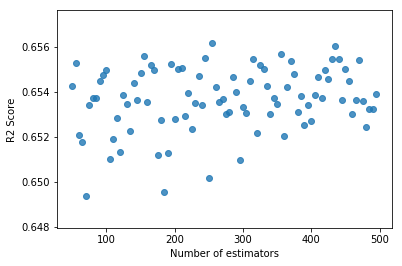

In [27]:
r2_error_by_trees.values()
import seaborn as sns
# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
sns_plot = sns.regplot(x=np.array(list(r2_error_by_trees.keys())), y=np.array(list(r2_error_by_trees.values())), fit_reg=False ) #order = 2)

# sns_plot.set_title('lalala')
sns_plot.set_ylabel('R2 Score')
sns_plot.set_xlabel('Number of estimators')

fig = sns_plot.get_figure()
fig.savefig("/Users/dsluis/Dropbox/UCL/UCL - Business Analytics specialisation in Computer Science/T3-COMPG099 - Dissertation/Diagrams/rf_oob_score_vs_number_of_estimators_efficient_1.png")




### Select 250 trees as the slope changes - very arbatary

In [55]:
def get_num_jobs():
    if sys.platform == 'win32':
        return 8
    else:
        if sys.platform == 'linux': # Sherlock ML
            return 8
        else:
            return 4 # mac

def MyGridSearchCV(param_grid, n_jobs, X, y, estimator):
    
    #Choose cross-validation generator - let's choose ShuffleSplit which randomly shuffles and selects Train and CV sets 
    #for each iteration. There are other methods like the KFold split.
    cv = ShuffleSplit(X.shape[0], n_iter=10, test_size=0.2)
    #Apply the cross-validation iterator on the Training set using GridSearchCV. This will run the classifier on the 
    #different train/cv splits using parameters specified and return the model that has the best results 

    # 
    #Note that we are tuning based on the F1 score 2PR/P+R where P is Precision and R is Recall. This may not always be 
    #the best score to tune our model on.  For now, we'll use F1.
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
    #Also note that we're feeding multiple neighbors to the GridSearch to try out. 
    #We'll now fit the training dataset to this classifier
    classifier.fit(X, y)
    #Let's look at the best estimator that was found by GridSearchCV
    print ("Best Estimator learned through GridSearch")
    print ( classifier.best_estimator_)
    return cv, classifier.best_estimator_, classifier
    


def print_info(best_est, X, y, tset):
    print ("--------------------------------" )
    print (tset+" Best Estimator Parameters" )
    print ("--------------------------------" )
    print ("n_estimators: %d" %best_est.n_estimators )
    print ("max_depth: %d" %best_est.max_depth )
    print ("max_features: %.2f" %best_est.max_features )
    print (tset+" R-squared: %.2f" %best_est.score(X,y) )  
#     print ("min_samples_leaf: %d" %best_est.min_samples_leaf ) 
#     print ("Learning Rate: %.2f" %best_est.learning_rate )

    
def perform_grid_search(X,y):

    # if no space left on device, try setting the env ver JOBLIB_TEMP_FOLDER to /tmp
    %env JOBLIB_TEMP_FOLDER=/tmp
    logger.info('starting')   
    
    param_grid={'n_estimators':[250], # 250
                'max_depth':[7,9,10,],      # 9
                'max_features':[5,7,13,15,17,19,21,23],   # 7
                'oob_score':[True],
                'bootstrap':[True],
                'verbose':[1],
                'n_jobs':[4]
               } 
    
    
    n_jobs = get_num_jobs() 

    #Let's fit GBRT to the digits training dataset by calling the function we just created. 
    estimator = ExtraTreesRegressor()

    cv, best_est, trained_model=MyGridSearchCV(param_grid, n_jobs, X, y, estimator) 
    logger.info('complete')
    print_info(best_est, X, y, '.8CV')
    
    return cv, best_est



In [56]:
print(X_eff_1.shape)
cv, best_est = perform_grid_search(X_eff_1, y_eff_1)

2018-08-10 13:01:16,442 __main__     INFO     starting


(3763, 43)
env: JOBLIB_TEMP_FOLDER=/tmp


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elaps

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elaps

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks    

[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 25

[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done 250 out of 25

[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  42 tasks    

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks    

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks    

[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  42 

[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done 192 tasks    

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elaps

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done 192 tasks    

Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=17, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=4,
          oob_score=True, random_state=None, verbose=1, warm_start=False)
--------------------------------
.8CV Best Estimator Parameters
--------------------------------
n_estimators: 250
max_depth: 10
max_features: 17.00
.8CV R-squared: 0.69


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.0s finished


In [57]:
print(cv)
print(best_est)

ShuffleSplit(3763, n_iter=10, test_size=0.2, random_state=None)
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=17, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=4,
          oob_score=True, random_state=None, verbose=1, warm_start=False)


In [58]:
best_est.score(X_eff_1, y_eff_1)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished


0.68838664582650133

# Split Data - to train real model

In [59]:
splitter = DataSplitter()
# X_train, X_test, y_train, y_test, in_train_set_by_id = splitter.get_test_train_datasets(X_eff_1, y_eff_1,
#                                                                                         docid_array_eff_1,7,train_split=0.50)



X_train, X_test, y_train, y_test = splitter.get_test_train_datasets_deterministic(X_eff_1, y_eff_1,
                                                                                      docid_array_eff_1,
                                                                                      Const.TRAINSET_DOCID_LIST)


In [60]:
# # Build a forest and compute the feature importances
# forest = ExtraTreesRegressor(n_estimators=best_est.n_estimators,
#                               random_state=0,
#                             oob_score=True, verbose=True, bootstrap = True)
forest = best_est
forest.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.2s finished


ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features=17, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=4,
          oob_score=True, random_state=None, verbose=1, warm_start=False)

# Save Model

In [61]:
output_filename = INTERMEDIATE_PATH+OUTPUT_MODEL_NAME
with open(output_filename, 'wb') as handle:
     pickle.dump(forest, handle, protocol=pickle.HIGHEST_PROTOCOL)




In [62]:
forest.score(X_train, y_train)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.0s finished


0.71713484703402097